# (11.0) Описание решаемой задачи

Необходимо проанализировать имеющиеся данные на наличие очевидных айсберг-заявок. Очевидными айсберг-заявками называются заявки, исполнение которых было произведено на сумму большую, чем было указано в выставленной заявке 

# (11.1) Установка необходимых пакетов

In [1]:
import pymysql.cursors
import os
import mysql.connector
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, date, time
from matplotlib import pyplot as plt

# (11.2) Список всех использующихся датафреймов¶

In [ ]:
# iceberg_all - список всех найденных айсбергов
# statistics_all - статистика по всем инструментам по количеству рыночных и лимитных заявок
# statistics_mean - средние значения по собранной статистике (для вставки в текст)
# ice_per_5min - список сгруппированных по 5ти минутным интервалам айсберг-заявок
# ice_day - сгруппированное по пятиминутным интервалам количество найденных айсберг-заявок внутри дня по всем инструментам
# ice_day - преобразованный датафрейм ice_per_5min с расчетом накопленного количества айсбергов внутри дня

# (11.3) Определение функций

In [90]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# выявление айсбергов
def iceberg(data_from_postgres):
    data = data_from_postgres
    #place - датафрейм (ДФ), который содержит наблюдения только по выставленным заявкам (ACTION = 1)
    #в ДФ содержатся данные по номеру заявки и выставленному объему (видимому)
    #iceberg = 1, если обнаружено, что выставленная заявка - айсберг. 0 - иначе
    #TIME_IDENT - время вскрытия заявки типа "айсберг". время указано для заявки, вскрывшей айсберг (снятие заявки или сделка) 
    place = data[data['ACTION']==1]
    place = place[['ORDERNO', 'VOLUME','SECCODE']]
    place['ICEBERG'] = 0
    place['TIME_IDENT'] = 0
    place['VOLUME_INI'] = 0
    place['VOLUME_INI'] = place['VOLUME']
    place.index = place['ORDERNO']
    
    #iceberg - ДФ с данными по снятым заявкам и по сделкам (ACTION = 0 или ACTION = 2)
    iceberg = data[data['ACTION']!=1]
    iceberg = iceberg.reset_index()
    iceberg = iceberg[['ORDERNO', 'VOLUME', 'TIME']]
    
    #Идея: 
    #ДФ place содержит только уникальные наблюдения по каждому ORDERNO (ORDERNO - уникальный ключ для ДФ place)
    #для каждой строки ДФ iceberg находит соответсвующее значение ORDERNO в ДФ place
    #если колонка VOLUME в ДФ place больше нуля, но меньше объема снятия/сделки, то код вычитает объем снятой заявки/сделки.
    #при этом в колонке TIME_IDENT выставляется время снятия/сделки (так как это действие вскрыло айсберг)
    #в колонке iceberg ставится значение 1, что идентифицирует айсберг

    #если колонка VOLUME в ДФ place больше нуля и объема снятия/сделки, код вычитает объем снятой заявки/сделки.
    #это действие необходимо, чтобы правильно идентифицировать айсберг, если он будет вскрыт в дальнейшем
    #других действий не совершается

    #в остальных случаях (если айсберг не будет вскрыт / уже был вскрыт) никаких действий с таблицей place не совершается
    #P.S. в остальных случаях на самом деле прибавляется ноль к значению VOLUME в ДФ place, но это лишь технический момент
    #прибавление нуля не повлияет на результаты
    
    for i in range(len(iceberg)):

        order_number = iceberg.loc[i, 'ORDERNO']

        if (place.loc[order_number, 'VOLUME'] >= 0) and (iceberg.loc[i, 'VOLUME'] > place.loc[order_number, 'VOLUME']):
            place.loc[order_number, 'VOLUME'] -= iceberg.loc[i, 'VOLUME']
            place.loc[order_number, 'TIME_IDENT'] = iceberg.loc[i, 'TIME']
            place.loc[order_number, 'ICEBERG'] = 1

        elif (place.loc[order_number, 'VOLUME'] >= 0) and (iceberg.loc[i, 'VOLUME'] < place.loc[order_number, 'VOLUME']):
            place.loc[order_number, 'VOLUME'] -= iceberg.loc[i, 'VOLUME']

        else:
            place.loc[order_number, 'VOLUME'] += 0
            
    #ice_detected - ДФ, содержащий все вскрытые заявки типа "айсберг" за выбранный период времени
    #Примечание: значение VOLUME отражает объем, на котором айсберг был вскрыт. 
    #В ходе дальнейших торгов VOLUME мог и дальше уходить в отрицательную зону
    ice_detected = place[place['ICEBERG']==1]
    ice_detected.index.names = ['Index']
    
    #количество вскрытых айсбергов за выбранный период времени
    #ice_numb = ice_detected['ICEBERG'].sum()
    
    #добавление времени выставления заявок, содержащих айсберги
    place = data[data['ACTION']==1]
    place_chd = place[['ORDERNO', 'BUYSELL','PRICE', 'TIME', 'DATE']]
    output = pd.merge(ice_detected, place_chd, on = 'ORDERNO', how = 'left')
    
    return output

# (11.4) Определение входных параметров 

In [10]:
# создаем список из всех названий файлов с данными (из них в дальнейшем можно извлечь дату)
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [11]:
# создаем список из инструментов
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

# (11.5) Выявление айсберг-заявоки их запись в файл

In [11]:
# поочередно читаем данные по каждому инструменту из каждого файла и сохраняем данные в отдельных файлах
for l in orderlogs:
    orderlog = pd.read_csv(l,header=0)
    d = l[8:16]
    for m in tickers:
        ticker = m
        instr_orderlog = orderlog[orderlog['SECCODE']==ticker]
        c
        output = iceberg(instr_orderlog)
        output_name = 'output/' + ticker + d + '.csv' # записываем результаты в разрезе дата-инструмент в файл
        output.to_csv(output_name,index=False)

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# (11.6) Сбор результатов в один файл

In [15]:
# сливаем результаты из всех файлов в один датафрейм
iceberg_all = pd.DataFrame()
for l in orderlogs:
    d = l[8:16]
    for m in tickers:
        ticker = m
        output_name = 'output/' +ticker + d + '.csv'
        df_temp = pd.read_csv(output_name,header=0)
        iceberg_all = pd.concat([iceberg_all,df_temp])
iceberg_all = iceberg_all.reset_index()         
iceberg_all

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI
0,0,B,20190304,1,199077,156.28,GAZP,100643595004,100936467866,-2830,2000
1,1,B,20190304,1,359638,156.18,GAZP,103027072289,105331759856,-210,2000
2,2,S,20190304,1,397852,156.58,GAZP,103657193855,103805393784,-3000,2000
3,3,B,20190304,1,486370,156.18,GAZP,105331809856,105342904115,-1000,1790
4,4,B,20190304,1,516105,156.03,GAZP,110003906212,110005256841,-1000,2000
...,...,...,...,...,...,...,...,...,...,...,...
54501,436,B,20190329,1,3821455,92.47,ALRS,183219963550,183219963586,-360,930
54502,437,B,20190329,1,3845898,92.58,ALRS,183514255473,183514256529,-1000,1000
54503,438,B,20190329,1,3845899,92.58,ALRS,183514255473,183514256529,-490,1000
54504,439,B,20190329,1,3845904,92.58,ALRS,183514257134,183514257134,-770,510


In [6]:
iceberg_all = pd.read_csv('iceberg.csv', header = 0)

In [7]:
# добавляем расчет времени между выставлением и выявлением айсберга
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']
iceberg_all

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
0,0,B,20190304,1,199077,156.28,GAZP,2019-03-04 10:06:43.595004,2019-03-04 10:09:36.467866,-2830,2000,00:02:52.872862
1,1,B,20190304,1,359638,156.18,GAZP,2019-03-04 10:30:27.072289,2019-03-04 10:53:31.759856,-210,2000,00:23:04.687567
2,2,S,20190304,1,397852,156.58,GAZP,2019-03-04 10:36:57.193855,2019-03-04 10:38:05.393784,-3000,2000,00:01:08.199929
3,3,B,20190304,1,486370,156.18,GAZP,2019-03-04 10:53:31.809856,2019-03-04 10:53:42.904115,-1000,1790,00:00:11.094259
4,4,B,20190304,1,516105,156.03,GAZP,2019-03-04 11:00:03.906212,2019-03-04 11:00:05.256841,-1000,2000,00:00:01.350629
...,...,...,...,...,...,...,...,...,...,...,...,...
54501,436,B,20190329,1,3821455,92.47,ALRS,2019-03-29 18:32:19.963550,2019-03-29 18:32:19.963586,-360,930,00:00:00.000036
54502,437,B,20190329,1,3845898,92.58,ALRS,2019-03-29 18:35:14.255473,2019-03-29 18:35:14.256529,-1000,1000,00:00:00.001056
54503,438,B,20190329,1,3845899,92.58,ALRS,2019-03-29 18:35:14.255473,2019-03-29 18:35:14.256529,-490,1000,00:00:00.001056
54504,439,B,20190329,1,3845904,92.58,ALRS,2019-03-29 18:35:14.257134,2019-03-29 18:35:14.257134,-770,510,00:00:00


In [8]:
iceberg_all.dtypes

index                   int64
BUYSELL                object
DATE                    int64
ICEBERG                 int64
ORDERNO                 int64
PRICE                 float64
SECCODE                object
TIME           datetime64[ns]
TIME_IDENT     datetime64[ns]
VOLUME                  int64
VOLUME_INI              int64
DELTA         timedelta64[ns]
dtype: object

In [110]:
# настраиваем типы данных
iceberg_all['VOLUME'] = iceberg_all['VOLUME'].astype('int')
iceberg_all['VOLUME_INI'] = iceberg_all['VOLUME_INI'].astype('int')
iceberg_all['DATE'] = iceberg_all['DATE'].astype('str')
iceberg_all.dtypes

index                                 int64
BUYSELL                              object
DATE                                 object
ICEBERG                              object
ORDERNO                              object
PRICE                               float64
SECCODE                              object
TIME                         datetime64[ns]
TIME_IDENT                   datetime64[ns]
VOLUME                                int64
VOLUME_INI                            int64
DELTA                       timedelta64[ns]
together_time                        object
together_time_identified             object
dtype: object

In [28]:
# сохраняем значения в файл
iceberg_all.to_csv('iceberg.csv',index=False)

# (11.7) Расчет статистики

In [24]:
# собираем статистику по всем инструментам по количеству рыночных и лимитных заявок
statistics_all = pd.DataFrame(columns = ['DATE','SECCODE','MARKET_COUNT','MARKER_VOL','LIMIT_COUNT','LIMIT_VOL','ICEBERG_COUNT','ICEBERG_VOL'])
for l in orderlogs:
    d = l[8:16]
    orderlog = pd.read_csv(l,header=0)
    for m in tickers:
        ticker = m
        market_count = len(orderlog.loc[(orderlog['PRICE']==0) & (orderlog['SECCODE']==ticker)])
        market_vol = orderlog.loc[(orderlog['PRICE']==0) & (orderlog['SECCODE']==ticker)]['VOLUME'].sum()
        limit_count = len(orderlog.loc[(orderlog['PRICE']!=0) & (orderlog['SECCODE']==ticker)])
        limit_vol = orderlog.loc[(orderlog['PRICE']!=0) & (orderlog['SECCODE']==ticker)]['VOLUME'].sum()
        iceberglog_name = 'output/' + ticker + d + '.csv'
        iceberglog = pd.read_csv(iceberglog_name,header=0)
        iceberg_count = len(iceberglog)
        iceberg_vol_ini = iceberglog.loc[(iceberglog['SECCODE']==ticker)]['VOLUME_INI'].sum()
        iceberg_vol = iceberglog.loc[(iceberglog['SECCODE']==ticker)]['VOLUME_INI'].sum() - iceberglog.loc[(iceberglog['SECCODE']==ticker)]['VOLUME'].sum()
        limit_count = limit_count - iceberg_count
        limit_vol = limit_vol - iceberg_vol_ini
        statistics_all.loc[len(statistics_all)] = [d,ticker,market_count,market_vol,limit_count,limit_vol,iceberg_count,iceberg_vol]

In [37]:
statistics_all

,DATE,SECCODE,MARKET_COUNT,MARKER_VOL,LIMIT_COUNT,LIMIT_VOL,ICEBERG_COUNT,ICEBERG_VOL
0,20190304,GAZP,5175,3196900,341398,939395640,174,540930
1,20190304,SBER,11329,8168960,421200,725092310,820,3398990
2,20190304,GMKN,4706,45796,169269,3389031,119,9053
3,20190304,LKOH,2406,50322,243075,17760148,286,75786
4,20190304,MTSS,963,148040,69730,58714310,27,169140
...,...,...,...,...,...,...,...,...
280,20190329,FIVE,676,15730,150611,42649904,28,13011
281,20190329,VTBR,3180,3011020000,172861,426002890000,276,2603310000
282,20190329,SNGS,1263,4369000,133490,1472837100,15,335200
283,20190329,CHMF,1132,81320,116562,25345670,17,32410


In [100]:
statistics_all['AVG_MARKET_VOL'] = statistics_all['MARKER_VOL']/statistics_all['MARKET_COUNT'] 
statistics_all['AVG_LIMIT_VOL'] = statistics_all['LIMIT_VOL']/statistics_all['LIMIT_COUNT'] 
statistics_all['AVG_ICEBERG_VOL'] = statistics_all['ICEBERG_VOL']/statistics_all['ICEBERG_COUNT']
statistics_all

,DATE,SECCODE,MARKET_COUNT,MARKER_VOL,LIMIT_COUNT,LIMIT_VOL,ICEBERG_COUNT,ICEBERG_VOL,AVG_MARKET_VOL,AVG_LIMIT_VOL,AVG_ICEBERG_VOL
0,20190304,GAZP,5175,3196900,341398,939395640,174,540930,617.758454,2.751614e+03,3.108793e+03
1,20190304,SBER,11329,8168960,421200,725092310,820,3398990,721.066290,1.721492e+03,4.145110e+03
2,20190304,GMKN,4706,45796,169269,3389031,119,9053,9.731407,2.002157e+01,7.607563e+01
3,20190304,LKOH,2406,50322,243075,17760148,286,75786,20.915212,7.306448e+01,2.649860e+02
4,20190304,MTSS,963,148040,69730,58714310,27,169140,153.727934,8.420237e+02,6.264444e+03
...,...,...,...,...,...,...,...,...,...,...,...
280,20190329,FIVE,676,15730,150611,42649904,28,13011,23.269231,2.831792e+02,4.646786e+02
281,20190329,VTBR,3180,3011020000,172861,426002890000,276,2603310000,946861.635220,2.464425e+06,9.432283e+06
282,20190329,SNGS,1263,4369000,133490,1472837100,15,335200,3459.224070,1.103331e+04,2.234667e+04
283,20190329,CHMF,1132,81320,116562,25345670,17,32410,71.837456,2.174437e+02,1.906471e+03


In [27]:
# сохраняем значения в файл
statistics_all.to_csv('statistics.csv',index=False)

In [82]:
statistics_all = pd.read_csv('statistics.csv',header=0)

In [101]:
# настраиваем типы данных
statistics_all['MARKET_COUNT'] = statistics_all['MARKET_COUNT'].astype('int')
statistics_all['MARKER_VOL'] = statistics_all['MARKER_VOL'].astype('int')
statistics_all['LIMIT_COUNT'] = statistics_all['LIMIT_COUNT'].astype('int')
statistics_all['LIMIT_VOL'] = statistics_all['LIMIT_VOL'].astype('int')
statistics_all['ICEBERG_COUNT'] = statistics_all['ICEBERG_COUNT'].astype('int')
statistics_all['ICEBERG_VOL'] = statistics_all['ICEBERG_VOL'].astype('int')
statistics_all['DATE'] = statistics_all['DATE'].astype('object')
statistics_all.dtypes

DATE                object
SECCODE             object
MARKET_COUNT         int64
MARKER_VOL           int64
LIMIT_COUNT          int64
LIMIT_VOL            int64
ICEBERG_COUNT        int64
ICEBERG_VOL          int64
AVG_MARKET_VOL     float64
AVG_LIMIT_VOL      float64
AVG_ICEBERG_VOL    float64
dtype: object

In [102]:
# подсчет средних значений по собранной статистике (для вставки в текст)
statistics_mean = np.round(statistics_all.pivot_table(index = 'SECCODE', aggfunc = np.mean),1)
statistics_mean

,AVG_ICEBERG_VOL,AVG_LIMIT_VOL,AVG_MARKET_VOL,ICEBERG_COUNT,ICEBERG_VOL,LIMIT_COUNT,LIMIT_VOL,MARKER_VOL,MARKET_COUNT
SECCODE,,,,,,,,,
ALRS,4263.1,2495.4,432.0,307.9,1.330669e+06,171519.7,4.259073e+08,1.183252e+06,2836.8
CHMF,1667.8,208.6,74.8,15.9,2.754840e+04,103343.6,2.217241e+07,7.606320e+04,1006.9
FIVE,344.0,231.5,21.9,56.2,1.675090e+04,113251.7,2.674378e+07,1.360450e+04,608.8
GAZP,4534.6,2562.9,644.0,345.3,1.514132e+06,406852.7,1.047982e+09,3.348828e+06,5191.6
GMKN,140.6,27.9,9.5,400.7,6.180770e+04,267028.5,7.776945e+06,3.965770e+04,4186.5
LKOH,288.6,79.2,24.7,198.0,5.443710e+04,288237.4,2.292297e+07,6.664280e+04,2713.7
MGNT,169.6,30.0,16.2,110.2,1.835090e+04,206898.9,6.308106e+06,3.975070e+04,2502.9
MTSS,3070.9,808.3,200.3,72.3,2.425179e+05,107248.8,8.678809e+07,3.194421e+05,1631.7
NVTK,1314.0,453.3,100.9,38.1,4.759110e+04,121437.5,5.442696e+07,9.153890e+04,911.8


In [ ]:
# определение среднего соотношения объема видимой части и общего объема айсберга
iceberg_all['SHARE'] = iceberg_all['VOLUME_INI']/(iceberg_all['VOLUME_INI'] - iceberg_all['VOLUME'])
iceberg_all['SHARE'].mean()

# (11.8) Построение графиков

In [9]:
import matplotlib.pyplot as plt

### 1.0 График среднего количества айсбергов внутри дня

In [288]:
%%time
# группируем все найденные айсберги по 5ти минутным интервалам
# ice_per_5min - список сгруппированных по 5ти минутным интервалам айсберг-заявок
ice_per_5min = []
icebergs = iceberg_all

for l in orderlogs:
    
    d = l[8:16]
    
    iceberg_instr = icebergs[(icebergs.DATE == int(d))]
    time_end = ReverseToDateTime(d + '100500000000') # определяем начальный момент времени
        
    while time_end <= ReverseToDateTime(d + '184500000000'): # определяем конечный момент времени
            
        time_begin = time_end - dt.timedelta(minutes=5)
        ice_count = iceberg_instr[(iceberg_instr.TIME >= time_begin) & (iceberg_instr.TIME <= time_end)]['SECCODE'].count()
        ice_vol = iceberg_instr[(iceberg_instr.TIME >= time_begin) & (iceberg_instr.TIME <= time_end)]['VOLUME_INI'].sum() - iceberg_instr[(iceberg_instr.TIME >= time_begin) & (iceberg_instr.TIME <= time_end)]['VOLUME'].sum()
        ice_flag = 0
            
        if ice_count != 0:
            ice_flag = 1
            
        ice_per_5min.append ([time_end, d, ticker, ice_flag, ice_count])
            
        time_end = time_end + dt.timedelta(minutes=5)

ice_per_5min = pd.DataFrame(ice_per_5min)
ice_per_5min.rename(columns={0: 'TIME', 1: 'DATE', 2: 'SECCODE', 3: 'FLAG', 4: 'ICE_COUNT', 5: 'ICE_VOL'}, inplace=True)
ice_per_5min

CPU times: user 14.1 s, sys: 169 ms, total: 14.3 s
Wall time: 15 s


,TIME,DATE,SECCODE,FLAG,ICE_COUNT
0,2019-03-04 10:05:00,20190304,LKOH,1,65
1,2019-03-04 10:10:00,20190304,LKOH,1,31
2,2019-03-04 10:15:00,20190304,LKOH,1,7
3,2019-03-04 10:20:00,20190304,LKOH,1,9
4,2019-03-04 10:25:00,20190304,LKOH,1,8
...,...,...,...,...,...
1990,2019-03-29 18:25:00,20190329,LKOH,1,51
1991,2019-03-29 18:30:00,20190329,LKOH,1,78
1992,2019-03-29 18:35:00,20190329,LKOH,1,119
1993,2019-03-29 18:40:00,20190329,LKOH,1,131


In [289]:
del ice_per_5min['FLAG']
del ice_per_5min['SECCODE']
ice_per_5min

,TIME,DATE,ICE_COUNT
0,2019-03-04 10:05:00,20190304,65
1,2019-03-04 10:10:00,20190304,31
2,2019-03-04 10:15:00,20190304,7
3,2019-03-04 10:20:00,20190304,9
4,2019-03-04 10:25:00,20190304,8
...,...,...,...
1990,2019-03-29 18:25:00,20190329,51
1991,2019-03-29 18:30:00,20190329,78
1992,2019-03-29 18:35:00,20190329,119
1993,2019-03-29 18:40:00,20190329,131


In [290]:
ice_per_5min.dtypes

TIME         datetime64[ns]
DATE                 object
ICE_COUNT             int64
dtype: object

In [291]:
# преобразуем датафрейм ice_per_5min так, чтобы по нему было удобно построить график
# ice_day - преобразованный датафрейм ice_per_5min с расчетом накопленного количества айсбергов внутри дня
ice_day = pd.DataFrame()

for l in orderlogs:
    
    d = l[8:16]
    
    if d == '20190304':
        
        ice_day = ice_per_5min[ice_per_5min.DATE == d].sort_values(by = 'TIME').reset_index()
        ice_day = ice_day.rename(columns = {'ICE_COUNT':'ICE_COUNT20190304'})
        ice_day['CUM20190304'] = ice_day['ICE_COUNT20190304'].cumsum()
        ice_day.TIME = [ice_day.TIME[i].time() for i in range (len(ice_day_1.TIME))]
        
    else:
        
        ice_day_1 = ice_per_5min[ice_per_5min.DATE == d].sort_values(by = 'TIME').reset_index()
        ice_day_1['CUM'] = ice_day_1['ICE_COUNT'].cumsum()
        ice_day_1.TIME = [ice_day_1.TIME[i].time() for i in range (len(ice_day_1.TIME))]
    
        ice_day = ice_day.merge(ice_day_1, on = 'TIME', how='outer')
        name1 = 'CUM' + d
        name2 = 'ICE_COUNT' + d
        #del ice_day['DATE_y']
        #del ice_day['index_y']
        ice_day = ice_day.rename(columns = {'CUM':name1,'ICE_COUNT':name2})

ice_day

,index_x,TIME,DATE_x,ICE_COUNT20190304,CUM20190304,index_y,DATE_y,ICE_COUNT20190305,CUM20190305,index_x,...,ICE_COUNT20190327,CUM20190327,index_y,DATE_y,ICE_COUNT20190328,CUM20190328,index,DATE,ICE_COUNT20190329,CUM20190329
0,0,10:05:00,20190304,65,65,105,20190305,19,19,210,...,114,114,1785,20190328,40,40,1890,20190329,65,65
1,1,10:10:00,20190304,31,96,106,20190305,30,49,211,...,46,160,1786,20190328,40,80,1891,20190329,37,102
2,2,10:15:00,20190304,7,103,107,20190305,43,92,212,...,29,189,1787,20190328,28,108,1892,20190329,56,158
3,3,10:20:00,20190304,9,112,108,20190305,96,188,213,...,105,294,1788,20190328,74,182,1893,20190329,12,170
4,4,10:25:00,20190304,8,120,109,20190305,33,221,214,...,58,352,1789,20190328,70,252,1894,20190329,24,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,18:25:00,20190304,2,2147,205,20190305,22,2776,310,...,22,2926,1885,20190328,14,2597,1990,20190329,51,2849
101,101,18:30:00,20190304,4,2151,206,20190305,93,2869,311,...,62,2988,1886,20190328,5,2602,1991,20190329,78,2927
102,102,18:35:00,20190304,1,2152,207,20190305,23,2892,312,...,71,3059,1887,20190328,41,2643,1992,20190329,119,3046
103,103,18:40:00,20190304,9,2161,208,20190305,16,2908,313,...,118,3177,1888,20190328,35,2678,1993,20190329,131,3177


In [249]:
# считаем среднее количество по всем айсбергам на каждую пятиминутку
ice_day['ICE_COUNT_MEAN'] = ice_day[['ICE_COUNT20190304', 
                                     'ICE_COUNT20190305', 
                                     'ICE_COUNT20190306',
                                     'ICE_COUNT20190307',
                                     'ICE_COUNT20190311',
                                     'ICE_COUNT20190312',
                                     'ICE_COUNT20190313',
                                     'ICE_COUNT20190314',
                                     'ICE_COUNT20190315',
                                     'ICE_COUNT20190318',
                                     'ICE_COUNT20190319',
                                     'ICE_COUNT20190320',
                                     'ICE_COUNT20190321',
                                     'ICE_COUNT20190322',
                                     'ICE_COUNT20190325',
                                     'ICE_COUNT20190326',
                                     'ICE_COUNT20190327',
                                     'ICE_COUNT20190328',
                                     'ICE_COUNT20190329']].mean(1)

# считаем среднее накопленное количество по всем айсбергам на каждую пятиминутку
ice_day['CUM_MEAN'] = ice_day[['CUM20190304', 
                                     'CUM20190305', 
                                     'CUM20190306',
                                     'CUM20190307',
                                     'CUM20190311',
                                     'CUM20190312',
                                     'CUM20190313',
                                     'CUM20190314',
                                     'CUM20190315',
                                     'CUM20190318',
                                     'CUM20190319',
                                     'CUM20190320',
                                     'CUM20190321',
                                     'CUM20190322',
                                     'CUM20190325',
                                     'CUM20190326',
                                     'CUM20190327',
                                     'CUM20190328',
                                     'CUM20190329']].mean(1)

ice_day

,index_x,TIME,DATE_x,ICE_COUNT20190304,CUM20190304,index_y,DATE_y,ICE_COUNT20190305,CUM20190305,index_x,...,index_y,DATE_y,ICE_COUNT20190328,CUM20190328,index,DATE,ICE_COUNT20190329,CUM20190329,ICE_COUNT_MEAN,CUM_MEAN
0,0,10:05:00,20190304,65,65,105,20190305,19,19,210,...,1785,20190328,40,40,1890,20190329,65,65,62.315789,62.315789
1,1,10:10:00,20190304,31,96,106,20190305,30,49,211,...,1786,20190328,40,80,1891,20190329,37,102,45.473684,107.789474
2,2,10:15:00,20190304,7,103,107,20190305,43,92,212,...,1787,20190328,28,108,1892,20190329,56,158,45.736842,153.526316
3,3,10:20:00,20190304,9,112,108,20190305,96,188,213,...,1788,20190328,74,182,1893,20190329,12,170,41.684211,195.210526
4,4,10:25:00,20190304,8,120,109,20190305,33,221,214,...,1789,20190328,70,252,1894,20190329,24,194,33.578947,228.789474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,18:25:00,20190304,2,2147,205,20190305,22,2776,310,...,1885,20190328,14,2597,1990,20190329,51,2849,35.842105,2732.894737
101,101,18:30:00,20190304,4,2151,206,20190305,93,2869,311,...,1886,20190328,5,2602,1991,20190329,78,2927,34.684211,2767.578947
102,102,18:35:00,20190304,1,2152,207,20190305,23,2892,312,...,1887,20190328,41,2643,1992,20190329,119,3046,48.526316,2816.105263
103,103,18:40:00,20190304,9,2161,208,20190305,16,2908,313,...,1888,20190328,35,2678,1993,20190329,131,3177,52.631579,2868.736842


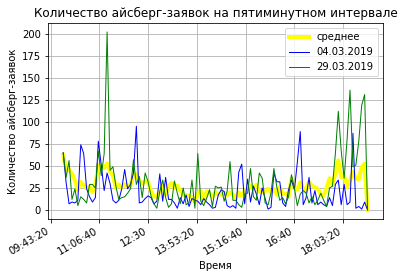

In [264]:
# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Количество айсберг-заявок на пятиминутном интервале')
plt.xlabel('Время')
plt.ylabel('Количество айсберг-заявок')
ax.plot(ice_day.TIME, ice_day.ICE_COUNT_MEAN, linestyle = '-', linewidth = 4, color = 'yellow', label = 'среднее')
ax.plot(ice_day.TIME, ice_day.ICE_COUNT20190304, linestyle = '-', linewidth = 1, color = 'blue', label = '04.03.2019')
ax.plot(ice_day.TIME, ice_day.ICE_COUNT20190329, linestyle = '-', linewidth = 1, color = 'green', label = '29.03.2019')
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()
fig.savefig('10 График среднего количества айсбергов внутри дня.png')

### 1.1 График среднего прироста айсберг заявок в течение дня

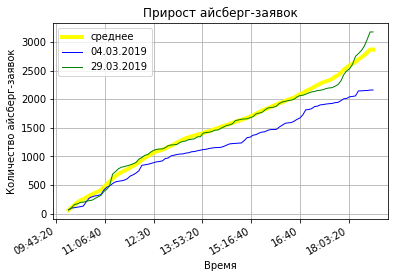

In [262]:
# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Прирост айсберг-заявок')
plt.xlabel('Время')
plt.ylabel('Количество айсберг-заявок')
ax.plot(ice_day.TIME, ice_day.CUM_MEAN, linestyle = '-', linewidth = 4, color = 'yellow', label = 'среднее')
ax.plot(ice_day.TIME, ice_day.CUM20190304, linestyle = '-', linewidth = 1, color = 'blue', label = '04.03.2019')
ax.plot(ice_day.TIME, ice_day.CUM20190329, linestyle = '-', linewidth = 1, color = 'green', label = '29.03.2019')
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()
fig.savefig('11 График среднего прироста айсберг заявок в течение дня.png')